In [2]:
!pip install gdown

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)


In [3]:
!pip install --upgrade torch torchvision torchaudio

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import gc
from itertools import islice
%matplotlib inline

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
from PIL import Image

### Setting up the data

In [5]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class LightCurveDataset(Dataset):
    def __init__(self, data_path, labels_file, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # load labels from the file
        with open(labels_file, "r") as f:
            lines = f.readlines()[3:]  # skip header lines
            for line in lines:
                # skip empty lines
                parts = line.strip().split()
                if len(parts) != 2:
                    continue
                filename, label = parts
                self.image_files.append(filename)
                self.labels.append(int(label))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # loading image
        img_path = os.path.join(self.data_path, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # convert images to grayscale
        
        # apply transformations
        if self.transform:
            image = self.transform(image)
        
        # get label
        label = self.labels[idx]
        return image, label

In [6]:
LC_data_path = 'Training_data' 
labels_file = 'labels.txt' 
LC_test_NEA_raw = 'Test_data'
LC_test_NEA_processed = 'Test_data_processed'
NEA_labels_file = 'NEA_labels.txt' 

# transformations to tensor
transform = transforms.Compose([transforms.Resize([128, 128]),
                                transforms.ToTensor()          
                                ])

# initializing the dataset
LC_dataset = LightCurveDataset(data_path=LC_data_path, labels_file=labels_file, transform=transform)
LC_test_raw_dataset = LightCurveDataset(data_path=LC_test_NEA_raw, labels_file=NEA_labels_file, transform=transform)
LC_test_proc_dataset = LightCurveDataset(data_path=LC_test_NEA_processed, labels_file=NEA_labels_file, transform=transform)

### Data Splitting

In [7]:
from torch.utils.data import random_split

In [8]:
# split dataset: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(LC_dataset))
valid_size = int(0.15 * len(LC_dataset))
test_size = len(LC_dataset) - train_size - valid_size

LC_train, LC_valid, LC_test = random_split(LC_dataset, [train_size, valid_size, test_size])

print(f"Training set size: {len(LC_train)}")
print(f"Validation set size: {len(LC_valid)}")
print(f"Test set size: {len(LC_test)}")

Training set size: 3114
Validation set size: 667
Test set size: 668


In [9]:
batch_size = 32  

# dataLoaders
train_loader = DataLoader(LC_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(LC_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(LC_test, batch_size=batch_size, shuffle=False)

# using real (raw and processed) data from NEA 
test_raw_loader = DataLoader(LC_test_raw_dataset, batch_size=12, shuffle=False)
test_proc_loader = DataLoader(LC_test_proc_dataset, batch_size=12, shuffle=False)

In [10]:
# number of real test data
len(LC_test_raw_dataset), len(LC_test_proc_dataset)

(12, 12)

In [11]:
model = nn.Sequential()

# 1st convolutional block                  # 1 for grayscale
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5)) # Retained dropout with p=0.5 to reduce overfitting

# 2nd convolutional block
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5)) # Retained dropout with p=0.5 to reduce overfitting

# 3rd convolutional block
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

# 4th convolutional block
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

# fully connected layer
# calculate the dimensions dynamically
x = torch.ones((4, 1, 128, 128))  # dummy input to infer dimensions
dims = model(x).shape
model.add_module('fc', nn.Linear(dims[1], 1))
model.add_module('sigmoid', nn.Sigmoid())

### Loss Function and Optimizer

In [13]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
# experiment with SGD with momentum and learning rates

In [15]:
num_epochs = 30
loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)
loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):
    ######## Training phase ########
    model.train()
    for x_batch, y_batch in train_loader:
        y_batch = y_batch.float()  # convert labels to float
        pred = model(x_batch).squeeze()  # make sure prediction matches label dimensions
        loss = loss_fn(pred, y_batch)
        loss.backward()  # backpropagation
        optimizer.step()  # update weights
        optimizer.zero_grad()  # reset gradients
        
        # calculate accuracy for training
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        loss_history_train[epoch] += loss.item() * y_batch.size(0)
        accuracy_history_train[epoch] += is_correct.sum().item()

    # normalize training metrics
    loss_history_train[epoch] /= len(train_loader.dataset)
    accuracy_history_train[epoch] /= len(train_loader.dataset)
    
    ######## Validation phase ########
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            y_batch = y_batch.float()  # Convert labels to float
            pred = model(x_batch).squeeze()
            loss = loss_fn(pred, y_batch)
            
            # Calculate accuracy for validation
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            loss_history_valid[epoch] += loss.item() * y_batch.size(0)
            accuracy_history_valid[epoch] += is_correct.sum().item()
    
    # normalize validation metrics
    loss_history_valid[epoch] /= len(valid_loader.dataset)
    accuracy_history_valid[epoch] /= len(valid_loader.dataset)
    
    # print metrics for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {loss_history_train[epoch]:.4f}, Train Accuracy: {accuracy_history_train[epoch]:.4f} | "
          f"Val Loss: {loss_history_valid[epoch]:.4f}, Val Accuracy: {accuracy_history_valid[epoch]:.4f}")

# cleanup
del x_batch, y_batch
del optimizer
gc.collect()
torch.cuda.empty_cache()

Epoch 1/30 | Train Loss: 0.6958, Train Accuracy: 0.5106 | Val Loss: 0.6932, Val Accuracy: 0.5022
Epoch 2/30 | Train Loss: 0.6930, Train Accuracy: 0.5173 | Val Loss: 0.6932, Val Accuracy: 0.5022
Epoch 3/30 | Train Loss: 0.6932, Train Accuracy: 0.5083 | Val Loss: 0.6933, Val Accuracy: 0.5022
Epoch 4/30 | Train Loss: 0.6929, Train Accuracy: 0.5173 | Val Loss: 0.6934, Val Accuracy: 0.5022
Epoch 5/30 | Train Loss: 0.6929, Train Accuracy: 0.5173 | Val Loss: 0.6932, Val Accuracy: 0.5022
Epoch 6/30 | Train Loss: 0.6928, Train Accuracy: 0.5173 | Val Loss: 0.6933, Val Accuracy: 0.5022
Epoch 7/30 | Train Loss: 0.6929, Train Accuracy: 0.5173 | Val Loss: 0.6932, Val Accuracy: 0.5022
Epoch 8/30 | Train Loss: 0.6929, Train Accuracy: 0.5100 | Val Loss: 0.6932, Val Accuracy: 0.5022
Epoch 9/30 | Train Loss: 0.6930, Train Accuracy: 0.5173 | Val Loss: 0.6933, Val Accuracy: 0.5022
Epoch 10/30 | Train Loss: 0.6926, Train Accuracy: 0.5173 | Val Loss: 0.6933, Val Accuracy: 0.5022
Epoch 11/30 | Train Loss: 0.6

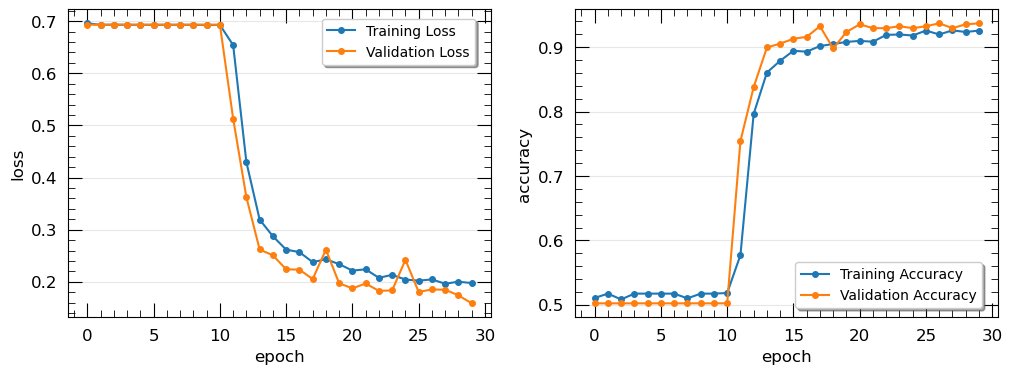

In [17]:
x_arr = np.arange(num_epochs)
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.set_xlabel('epoch', fontsize=12)
ax.set_ylabel('loss', fontsize=12)
ax.minorticks_on()
ax.tick_params(which='major', direction='in', top=True, right=True, length=10, pad=8, labelsize=12)
ax.tick_params(which='minor', direction='in', top=True, right=True, length=5, pad=8)
ax.grid(axis='y', alpha=0.3)
ax.plot(x_arr, loss_history_train, '-o', ms=4, label='Training Loss')
ax.plot(x_arr, loss_history_valid, '-o', ms=4, label='Validation Loss')
plt.legend(loc=(0.60,0.82), prop={'size': 10}, shadow=True)

ax=fig.add_subplot(1,2,2)
ax.set_xlabel('epoch', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)
ax.minorticks_on()
ax.tick_params(which='major', direction='in', top=True, right=True, length=10, pad=8, labelsize=12)
ax.tick_params(which='minor', direction='in', top=True, right=True, length=5, pad=8)
ax.grid(axis='y', alpha=0.3)
ax.plot(x_arr, accuracy_history_train, '-o', ms=4, label='Training Accuracy')
ax.plot(x_arr, accuracy_history_valid, '-o', ms=4, label='Validation Accuracy')
plt.legend(loc=(0.52,0.03), prop={'size': 10}, shadow=True);

In [ ]:
# Training loss measures how well the model is performing on the training data
# It indicates how well the model is learning the patterns in the training data

# Validation loss measures how well the model is performing on unseen data (validation set) that is not used for training
# Used to monitor overfitting or underfitting

In [ ]:
# Observations:
# Training Loss: 
#    - decreases steadily and plateaus at a low value, which indicates the model is effectively learning 
#      patterns from the training data
#    - There are no signs of underfitting. Both training and validation loss decrease significantly, 
#      and the accuracy improves to ~90–95%.
# Validation Loss:
#    - Closely follows the training loss initially, indicating the model generalizes well during the early epochs
#    - After epoch ~10, the validation loss begins to fluctuate slightly but remains close to the training loss, 
#      suggesting no significant overfitting
#    - There are no major signs of overfitting. The validation loss and validation accuracy closely track the training metrics, 
#      even after convergence.
# Training Accuracy:
#    - Increases steadily and plateaus around ~95%, which matches the behavior of the training loss
#    - Tracks closely with the training accuracy, stabilizing at ~90–95%, which is a good sign that the model is generalizing well.

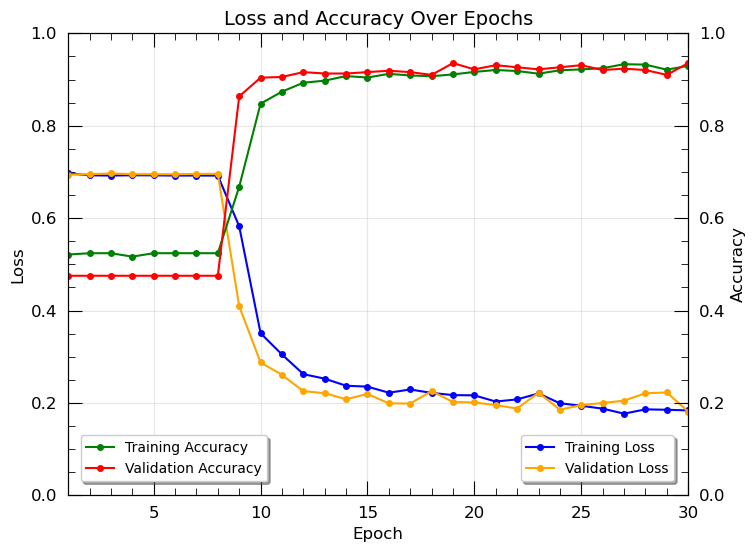

In [15]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_title("Loss and Accuracy Over Epochs", fontsize=14)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.minorticks_on()
ax1.tick_params(which='major', direction='in', top=True, right=True, length=10, pad=8, labelsize=12)
ax1.tick_params(which='minor', direction='in', top=True, right=True, length=5, pad=8)
ax1.plot(range(1, len(loss_history_train) + 1), loss_history_train, 'o-', ms=4, label="Training Loss", color="blue")
ax1.plot(range(1, len(loss_history_valid) + 1), loss_history_valid, 'o-', ms=4, label="Validation Loss", color="orange")
ax1.legend(loc=(0.73,0.03), prop={'size': 10}, shadow=True)
ax1.grid(alpha=0.3)

ax1.set_xlim([1, len(loss_history_train)])

ax2 = ax1.twinx()
ax2.set_ylim(0, 1)
ax2.plot(range(1, len(accuracy_history_train) + 1), accuracy_history_train, 'o-', ms=4, label="Training Accuracy", color="green")
ax2.plot(range(1, len(accuracy_history_valid) + 1), accuracy_history_valid, 'o-', ms=4, label="Validation Accuracy", color="red")
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.minorticks_on()
ax2.tick_params(which='major', direction='in', top=True, right=True, length=10, pad=8, labelsize=12)
ax2.tick_params(which='minor', direction='in', top=True, right=True, length=5, pad=8)
ax2.legend(loc=(0.02,0.03), prop={'size': 10}, shadow=True)

plt.show()

### Analyzing Test Data

In [16]:
accuracy_history_test = 0.
with torch.no_grad(): # don't optimize at this point, i.e. keep all weights fixed 
    for x_batch, y_batch in test_loader:
        pred = model(x_batch)[:, 0]
        is_correct = ( (pred>=.5).float() == y_batch).float()
        accuracy_history_test += is_correct.sum()
    accuracy_history_test /= len(test_loader.dataset)
    
    print(f"Final accuracy: {accuracy_history_test:.4f} ")

pred = model(x_batch)[:, 0] * 100. # these are the computed probabilities of whether a test light curve has an exoplanet or not

Final accuracy: 0.9341 


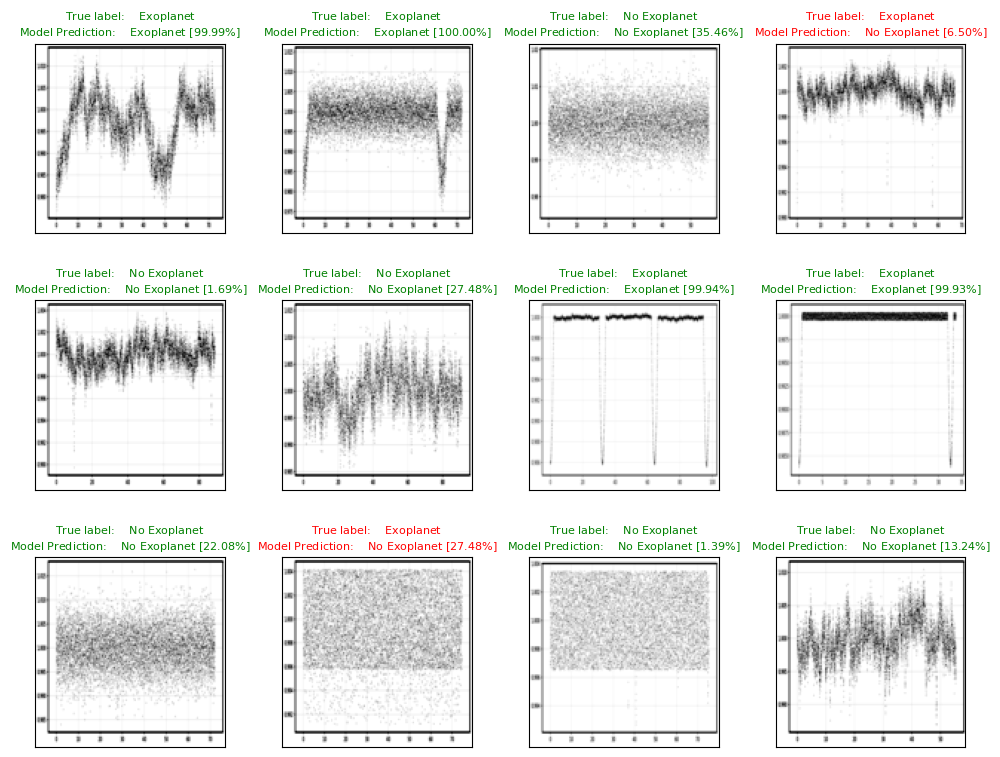

In [17]:
model.eval()
# disabling gradients to save memory and computation time
with torch.no_grad():
    data_loader = DataLoader(LC_dataset, batch_size=12, shuffle=True)
    # getting one batch of test data
    img_batch, label_batch = next(iter(data_loader))  
    
    # raw model outputs for each image
    pred = model(img_batch)[:, 0]
    # scaling to percentages
    probabilities = (pred * 100).cpu().numpy()   # converting PyTorch tensors to NumPy arrays
    # binary classification threshold of 0.5
    predictions = (pred >= 0.5).float().cpu().numpy() 

# Define the grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# Loop through each image and corresponding axes
for jj, ax in enumerate(axes.flat):  
    ax.set_xticks([])
    ax.set_yticks([])
    
    img = img_batch[jj]
    ax.imshow(img.permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray")  
    
    true_label = "Exoplanet" if label_batch[jj] == 1 else "No Exoplanet"
    predicted_label = "Exoplanet" if predictions[jj] == 1 else "No Exoplanet"
    probability = probabilities[jj]
    ax.set_title(f"True label:$\quad$ {true_label}\nModel Prediction:$\quad$ {predicted_label} [{probability:.2f}%]",
                 fontsize=8, color="g" if true_label == predicted_label else "r")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.001, wspace=0.3)  # hspace affects row spacing, wspace affects column spacing

plt.show()

### Raw Test Data

In [18]:
accuracy_history_test = 0.
with torch.no_grad(): # don't optimize at this point, i.e. keep all weights fixed 
    for x_batch, y_batch in test_raw_loader:
        pred = model(x_batch)[:, 0]
        is_correct = ( (pred>=.5).float() == y_batch).float()
        accuracy_history_test += is_correct.sum()
    accuracy_history_test /= len(test_raw_loader.dataset)
    
    print(f"Final accuracy: {accuracy_history_test:.4f} ")

pred = model(x_batch)[:, 0] * 100. # these are the computed probabilities of whether a test light curve has an exoplanet or not

Final accuracy: 0.5833 


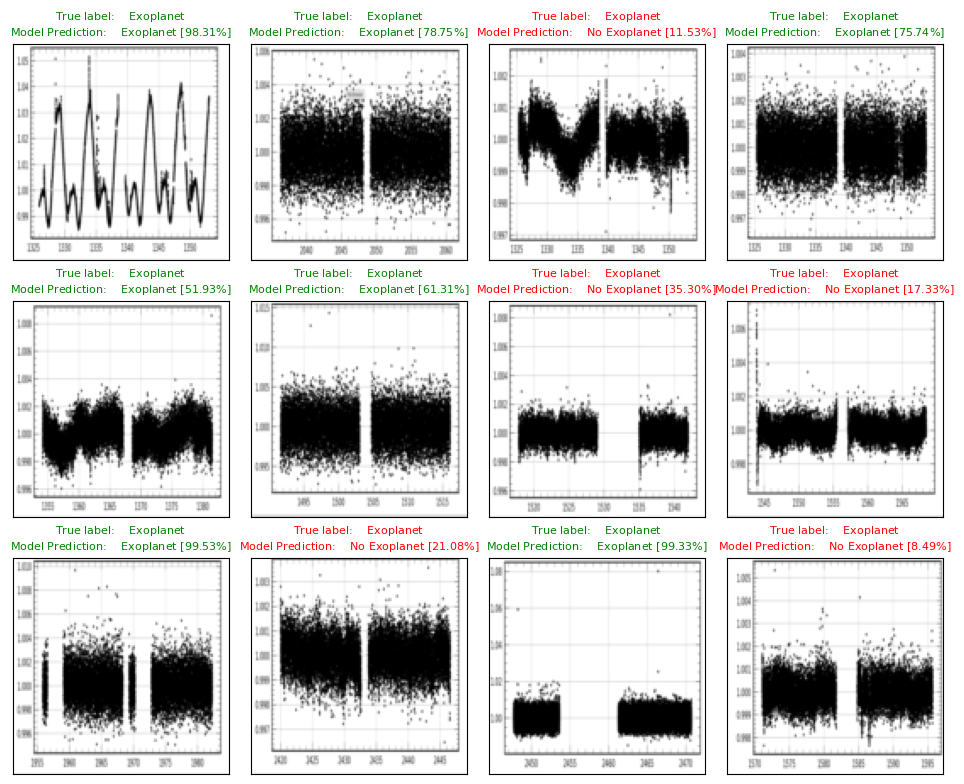

In [28]:
model.eval()
# disabling gradients to save memory and computation time
with torch.no_grad():
    data_loader = DataLoader(LC_test_raw_dataset, batch_size=12, shuffle=False)
    # getting one batch of test data
    img_batch, label_batch = next(iter(data_loader))  
    
    # raw model outputs for each image
    pred = model(img_batch)[:, 0]
    # scaling to percentages
    probabilities = (pred * 100).cpu().numpy()   # converting PyTorch tensors to NumPy arrays
    # binary classification threshold of 0.5
    predictions = (pred >= 0.5).float().cpu().numpy() 

# Define the grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# Loop through each image and corresponding axes
for jj, ax in enumerate(axes.flat):  
    ax.set_xticks([])
    ax.set_yticks([])
    
    img = img_batch[jj]
    ax.imshow(img.permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray")  
    
    true_label = "Exoplanet" if label_batch[jj] == 1 else "No Exoplanet"
    predicted_label = "Exoplanet" if predictions[jj] == 1 else "No Exoplanet"
    probability = probabilities[jj]
    ax.set_title(f"True label:$\quad$ {true_label}\nModel Prediction:$\quad$ {predicted_label} [{probability:.2f}%]",
                 fontsize=8, color="g" if true_label == predicted_label else "r")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.001, wspace=0.1)  # hspace affects row spacing, wspace affects column spacing

plt.show()

### Processed Test Data

In [20]:
accuracy_history_test = 0.
with torch.no_grad(): # don't optimize at this point, i.e. keep all weights fixed 
    for x_batch, y_batch in test_proc_loader:
        pred = model(x_batch)[:, 0]
        is_correct = ( (pred>=.5).float() == y_batch).float()
        accuracy_history_test += is_correct.sum()
    accuracy_history_test /= len(test_proc_loader.dataset)
    
    print(f"Final accuracy: {accuracy_history_test:.4f} ")

pred = model(x_batch)[:, 0] * 100. # these are the computed probabilities of whether a test light curve has an exoplanet or not

Final accuracy: 0.5000 


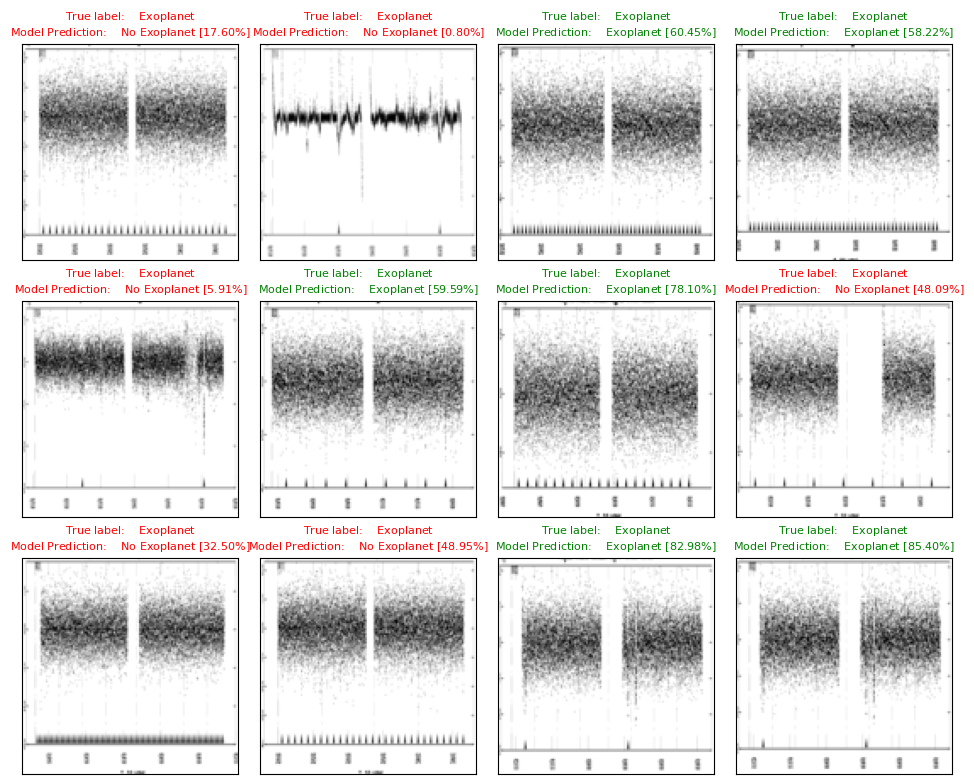

In [27]:
model.eval()
# disabling gradients to save memory and computation time
with torch.no_grad():
    data_loader = test_proc_loader
    # getting one batch of test data
    img_batch, label_batch = next(iter(data_loader))  
    
    # raw model outputs for each image
    pred = model(img_batch)[:, 0]
    # scaling to percentages
    probabilities = (pred * 100).cpu().numpy()   # converting PyTorch tensors to NumPy arrays
    # binary classification threshold of 0.5
    predictions = (pred >= 0.5).float().cpu().numpy() 

# Define the grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# Loop through each image and corresponding axes
for jj, ax in enumerate(axes.flat):  
    ax.set_xticks([])
    ax.set_yticks([])
    
    img = img_batch[jj]
    ax.imshow(img.permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray")  
    
    true_label = "Exoplanet" if label_batch[jj] == 1 else "No Exoplanet"
    predicted_label = "Exoplanet" if predictions[jj] == 1 else "No Exoplanet"
    probability = probabilities[jj]
    ax.set_title(f"True label:$\quad$ {true_label}\nModel Prediction:$\quad$ {predicted_label} [{probability:.2f}%]",
                 fontsize=8, color="g" if true_label == predicted_label else "r")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.001, wspace=0.1)  # hspace affects row spacing, wspace affects column spacing

plt.show()